In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import os


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

# training data
image_size = 224

species = ['Apple', 'Bell Pepper', 'Blueberry', 'Cherry (including sour)',
       'Corn (maize)', 'Grape', 'Orange', 'Peach', 'Potato', 'Raspberry',
       'Soybean', 'Squash', 'Strawberry', 'Tomato']

classes = ['Apple Black rot', 'Apple Cedar apple rust', 'Apple healthy',
       'Apple scab', 'Bell Pepper Bacterial spot', 'Bell Pepper healthy',
       'Blueberry healthy', 'Cherry (including sour) Powdery mildew',
       'Cherry (including sour) healthy',
       'Corn (maize) Cercospora leaf spot Gray leaf spot',
       'Corn (maize) Common rust ', 'Corn (maize) Northern Leaf Blight',
       'Corn (maize) healthy', 'Grape Black rot',
       'Grape Esca (Black Measles)',
       'Grape Leaf blight (Isariopsis Leaf Spot)', 'Grape healthy',
       'Orange Haunglongbing (Citrus greening)', 'Peach Bacterial spot',
       'Peach healthy', 'Potato Early blight', 'Potato Late blight',
       'Potato healthy', 'Raspberry healthy', 'Soybean healthy',
       'Squash Powdery mildew', 'Strawberry Leaf scorch',
       'Strawberry healthy', 'Tomato Bacterial spot',
       'Tomato Early blight', 'Tomato Late blight', 'Tomato Leaf Mold',
       'Tomato Septoria leaf spot',
       'Tomato Spider mites Two-spotted spider mite',
       'Tomato Target Spot', 'Tomato Yellow Leaf Curl Virus',
       'Tomato healthy', 'Tomato mosaic virus']

In [15]:
# import image data and combine labels
def load_data(image_size=224, image_dir='data/multipleplants'):
    X = []
    y=[]
    labels =[]
    for root, folder, files in os.walk(image_dir):
        #print( folder)
        for f in files:
            #print(f)
            if f.lower().endswith('.jpg') or f.lower().endswith('.png') or f.lower().endswith('.jpeg'):
                #print(root, folder, f)
                img = load_img(f'{root}/{f}', target_size=(image_size,image_size,3))
                img_array = img_to_array(img, dtype='uint8')
                X.append(img_array)
                
                # get y
                specie, classname = root[20:].split('___')
                specie = specie.replace('_', ' ')
                classname = classname.replace('_', ' ')
                if classname[:len(specie)].lower() != specie.lower():
                    classname=specie +' ' + classname
                #print(species.index(specie), classes.index(classname))
                y.append([species.index(specie), classes.index(classname)])
                labels.append([specie, classname])
                
    return np.array(X, dtype=np.uint8), np.array(y), np.array(labels)

In [16]:
# import training data and combine labels
data_x, data_y  = load_data() 

ValueError: too many values to unpack (expected 2)

## Augmentation

In [4]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)


In [5]:
def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])

## Transfer Learning

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.20, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

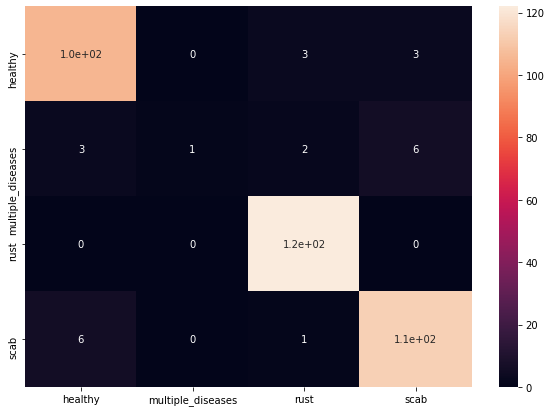

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

## Convert to TFLite

In [7]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("models/EfficientNetB2") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('models/EfficientNetB2.tflite', 'wb') as f:
    f.write(tflite_model)

In [8]:
len(x_val)

365

In [170]:
import cv2
for i in range(5):
    index = np.random.randint(len(x_train))
    print(f"====TF Model result{index}====")
    print(model.predict(np.expand_dims(x_train[index],axis=0)))
    print(y_train[index])

    interpreter = tf.lite.Interpreter(model_path="models/InceptionResNetV2.tflite")
    interpreter.allocate_tensors()
    # Get input and output tensors.
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    img = cv2.resize(x_train[index], (299,299)).astype('float32')

    input_data = np.expand_dims(img, axis = 0)
    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = interpreter.get_tensor(output_details[0]['index'])
    print("====TFLite result====")
    print(output_data)
    print(np.argmax(output_data))

====TF Model result320====
[[-8.098623  20.280613  32.872677   2.0342734]]
2
====TFLite result====
[[-9.241392  17.788212  24.103294   1.4423556]]
2
====TF Model result936====
[[ 1.759156   3.3063276 -7.695839  10.443231 ]]
3
====TFLite result====
[[ 1.0762084  2.9396756 -4.690091   6.0408373]]
3
====TF Model result471====
[[-4.4430866 10.752027  16.968367   0.971059 ]]
2
====TFLite result====
[[-8.857941  16.679115  22.27221    1.2956066]]
2
====TF Model result205====
[[-6.6743484 16.36166   26.331352   1.2265841]]
2
====TFLite result====
[[-10.058701   18.861298   25.171555    1.3159931]]
2
====TF Model result910====
[[ 0.7219937  2.9152334 -4.7115536  9.597789 ]]
3
====TFLite result====
[[ 0.5466095  3.327868  -2.708939   5.211375 ]]
3
